# PCA (Principal Component Analysis) via EVD and SVD

*This notebook is inspired by 2 articles: [svd in pca](https://towardsdatascience.com/svd-in-machine-learning-pca-f25cf9b837ae) and [pca tutorial](https://towardsdatascience.com/principal-component-analysis-your-tutorial-and-code-9719d3d3f376)* 

This notebook aimes at getting an intuition for how **Principal Component Analysis** algorithm, used for Dimension Reduction, can be implemented via:
- `EVD` (Eigenvalue Decomposition)
- `SVD` (Singular Value Decomponsition)
and why `SVD` implmentation is better.

### Principal Component Analysis
*Intuitively*, **PCA** is a transformation procedure that converts a data matrix with possibly correlated features into a set of linearly uncorrelated variables called principal components.  
Each **principal component** is a linear combination of the original features: `PCᵢ = Xϕᵢ`   
where PCᵢ stands for the i-th principal component.  It accounts for the largest possible variance while being orthogonal to the preceding components:  
`if i≠ j, PCᵢ ⋅ PCⱼ = 0`

Given a feature matrix **X** of shape `n × p` that is **centered**, i.e. column means have been subtracted and are now equal to zero, typical use cases of PCA include:
- **Dimensionality reduction**: find a lower-dimensional approximation of X of shape `n × **k**` (where **k** is much smaller than p) while *maintaining most of the variances*, as a preprocessing step for classification or visualization.
- **Feature engineering**: create a new representation of X with `p` linearly uncorrelated features.
- **Unsupervised learning**: extract `k` **principal components** (where k is often much smaller than p). Understand the dataset by looking at how are the original features contributing to these factors.  
Conceptually, it’s important to keep in mind that PCA is an approach of *multivariate data analysis* and both `EVD` and `SVD` are numerical methods.

## 1. PCA through EVD (Eigenvalue Value Decomposition)
From a high-level view PCA has three main steps:
- (1) Compute the **covariance matrix** of the data
- (2) Compute the **eigen values and vectors** of this covariance matrix
- (3) Use the eigen values and vectors to **select only the most important feature vectors** and then transform your data onto those vectors for reduced dimensionality!


### 1.1 Computing the covariance matrix
PCA yields a feature subspace that maximizes the variance along the feature vectors.  
Therefore, in order to properly measure the variance of those feature vectors, they must be *properly balanced*.  

To accomplish this, we first **normalise our data to have zero-mean and unit-variance** such that each feature will be weighted equally in our calculations.  

We can do that with `StandardScaler` from sklearn that standardize features by removing the mean and scaling to unit variance.  
StandardScaler results in a distribution with a standard deviation equal to 1. The variance is equal to 1 also, because variance = standard deviation squared. And 1 squared = 1. StandardScaler makes the mean of the distribution 0.  About 68% of the values will lie be between -1 and 1.

In [1]:
from sklearn.preprocessing import StandardScaler

def sk_normalize(X):
    # Center X and get covariance matrix C    
    return StandardScaler().fit_transform(X)


In [2]:
import numpy as np
X = np.array([[0, 3, 4], [1, 2, 4], [3, 4, 5]])
X_norm = sk_normalize(X)
print("X:\n", X) 
print("Normalized matrix:\n", X_norm) 
print("Normalized matrix has zero mean:\n", X_norm.mean(axis=0)) 
print("Normalized matrix has unit variance:\n", X_norm.std(axis=0)) 


X:
 [[0 3 4]
 [1 2 4]
 [3 4 5]]
Normalized matrix:
 [[-1.06904497  0.         -0.70710678]
 [-0.26726124 -1.22474487 -0.70710678]
 [ 1.33630621  1.22474487  1.41421356]]
Normalized matrix has zero mean:
 [7.40148683e-17 0.00000000e+00 5.92118946e-16]
Normalized matrix has unit variance:
 [1. 1. 1.]


Covariance provides a measure of strength of correlation between two variable or more set of variables.:
- If COV(xi, xj) = 0 then variables are uncorrelated
- If COV(xi, xj) > 0 then variables positively correlated
- If COV(xi, xj) > < 0 then variables negatively correlated

The covariance matrix is then just an array where each value specifies the covariance between two feature variables based on the x-y position in the matrix. The formula is:

![](images/covariance_1.png)

Where the `x` with the line on top is a vector of mean values for each feature of X.  
Notice that when we multiply a transposed matrix by the original one we end up multiplying each of the features for each data point together!

This formula becomes simpler if we assume that **X is centered**:

![](images/evd_math.png)

In [3]:
print(X)
print("X.mean:", X.mean(axis=0))
print("X.mean:", X.shape)

[[0 3 4]
 [1 2 4]
 [3 4 5]]
X.mean: [1.33333333 3.         4.33333333]
X.mean: (3, 3)


In [4]:
def np_cov_base(X):
    # We can do this with one line of numpy:
    cov_mat = np.cov(X.T)
    return cov_mat

def np_cov_math(X):
    # Or we can do that using our math formula from nefore and implement the convariance ourselves
    # Note - X is supposed to have been normalized
    # Compute the mean of the data
    n, p = X.shape
    x_mean_vec = np.mean(X, axis=0)
    X_centered = X - x_mean_vec

    # Compute the covariance matrix
    cov_mat = X_centered.T.dot(X_centered) / (n-1)
    return cov_mat


In [6]:
print("X_norm:\n", X_norm) 
print("Numpy Covariance matrix of X_norm using np.cov():\n", np_cov_base(X_norm)) 
print("Numpy Covariance matrix of X_norm using our formula:\n", np_cov_math(X_norm)) 
assert (np_cov_base(X_norm).all() == np_cov_math(X_norm).all())

X_norm:
 [[-1.06904497  0.         -0.70710678]
 [-0.26726124 -1.22474487 -0.70710678]
 [ 1.33630621  1.22474487  1.41421356]]
Numpy Covariance matrix of X_norm using np.cov():
 [[1.5        0.98198051 1.41736677]
 [0.98198051 1.5        1.29903811]
 [1.41736677 1.29903811 1.5       ]]
Numpy Covariance matrix of X_norm using our formula:
 [[1.5        0.98198051 1.41736677]
 [0.98198051 1.5        1.29903811]
 [1.41736677 1.29903811 1.5       ]]


#### Plot the covariance matrix

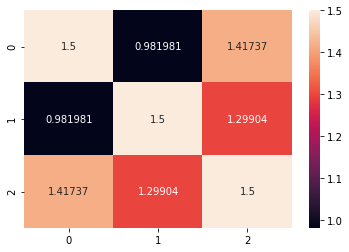

In [39]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(np_cov_math(X_norm), annot=True, fmt='g')
plt.show()

### 1.2.Computing Eigen Values and Vectors
The **eigen vectors** (principal components) of our covariance matrix represent the vector directions of the new feature space and the eigen values represent the magnitudes of those vectors. Since we are looking at our covariance matrix the eigen values quantify the contributing variance of each vector.

If an eigen vector has a corresponding eigen value of **high magnitude** it means that our data has **high variance** along that vector in feature space. Thus, this vector **holds a lot information about our data**, since any movement along that vector causes large “variance”. 

On the other hand vectors with small eigen values have low variance and thus our data does not vary greatly when moving along that vector. Since nothing changes when moving along that particular feature vector i.e changing the value of that feature vector does not greatly effect our data, then we can say that this feature isn’t very important and we can afford to remove it.


That’s the whole essence of eigen values and vectors within PCA. **Find the vectors that are the most important in representing our data and discard the rest**. 

Computing the eigen vectors and values of our covariance matrix is an easy one-liner in numpy using `linalg.eig`. After that, we’ll sort the eigen vectors in descending order based on their eigen values.

In [7]:
def get_eigen_vectors(X):
    # Compute the eigen values and vectors using numpy
    eig_vals, eig_vecs = np.linalg.eig(X)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    return eig_pairs

In [9]:
X_cov = np_cov_math(X_norm)
X_cov

array([[1.5       , 0.98198051, 1.41736677],
       [0.98198051, 1.5       , 1.29903811],
       [1.41736677, 1.29903811, 1.5       ]])

In [10]:
get_eigen_vectors(X_cov)

[(3.9743011006533293, array([-0.5688248 , -0.54782261, -0.61345639])),
 (0.5256988993466694, array([-0.63812818,  0.76452977, -0.09103102])),
 (3.0282963384800443e-16, array([-0.51887452, -0.33968311,  0.78446454]))]

### 1.3.Projection onto new vectors
At this point we have a list of eigen vectors sorted in order of “importance” to our dataset based on their eigen values. Now what we want to do is **select the most important feature vectors** that we need and discard the rest. We can do this in a clever way by looking at the explained variance percentage of the vectors. This percentage quantifies how much information (variance) can be attributed to each of the principal components out of the total 100%.

Let’s take an example to illustrate. Say we have a dataset which originally has 10 feature vectors. After computing the covariance matrix, we discover that the eigen values are:  
`[12, 10, 8, 7, 5, 1, 0.1, 0.03, 0.005, 0.0009]`  
The total sum of this array is = `43.1359`  
But the first 6 values represent: `42 / 43.1359 = 99.68%` of the total!   

That means that our first 5 eigen vectors effectively hold 99.68% of the variance or information about our dataset. We can thus discard the last 4 feature vectors as they only contain 0.32% of the information, a worthy sacrifice for saving on 40% of the computations!

Therefore, we can simply define a threshold upon which we can decide whether to keep or discard each feature vector. In the code below, we simply count the number of feature vectors we would like to keep based on a selected threshold of 97%.

In [11]:
# Only keep a certain number of eigen vectors based on 
# the "explained variance percentage" which tells us how 
# much information (variance) can be attributed to each 
# of the principal components

def filter_eig_vectors(eig_vals, exp_var_percentage):
    tot = sum(eig_vals)
    var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)

    num_vec_to_keep = 0

    for index, percentage in enumerate(cum_var_exp):
        if percentage > exp_var_percentage:
            num_vec_to_keep = index + 1
            break
    return num_vec_to_keep

In [12]:
X_eigh_pairs = get_eigen_vectors(X_cov)
X_eigh_pairs


[(3.9743011006533293, array([-0.5688248 , -0.54782261, -0.61345639])),
 (0.5256988993466694, array([-0.63812818,  0.76452977, -0.09103102])),
 (3.0282963384800443e-16, array([-0.51887452, -0.33968311,  0.78446454]))]

In [13]:
X_eigh_values = [item[0] for item in X_eigh_pairs]
X_eigh_values


[3.9743011006533293, 0.5256988993466694, 3.0282963384800443e-16]

In [14]:
vector_to_keep = filter_eig_vectors(X_eigh_values, 0.99)
vector_to_keep

2

In [15]:
vector_to_keep = filter_eig_vectors(X_eigh_values, 0.50)
vector_to_keep

1

In [16]:
vector_to_keep = filter_eig_vectors([12, 10, 8, 7, 5, 1, 0.1, 0.03, 0.005, 0.0009], 0.99)
vector_to_keep

6

The final step is to actually **project our data onto the vectors we decided to keep**. 

We do this by building a projection matrix: that’s just a fancy word for a matrix we will multiply by to project our data onto the new vectors. To create it, we simply concatenate all of the eigen vectors we decided to keep. Our final step is to simply take the dot product between our original data and our projection matrix.
Voila! Dimensions reduced with EVD!

In [17]:
# Compute the projection matrix based on the top eigen vectors
def pca_evd_proj_matrix(X, eig_pairs, num_vec_to_keep):
    num_features = X.shape[1]
    proj_mat = eig_pairs[0][1].reshape(num_features,1)
    for eig_vec_idx in range(1, num_vec_to_keep):
      proj_mat = np.hstack((proj_mat, eig_pairs[eig_vec_idx][1].reshape(num_features,1)))

    # Project the data 
    pca_data = X.dot(proj_mat)
    
    return pca_data

In [18]:
X_eigh_pairs = get_eigen_vectors(X_cov)
print('X', X)
print('X_eigh_pairs:', X_eigh_pairs)

vector_to_keep = filter_eig_vectors(X_eigh_values, 0.99)
print('vector_to_keep:', vector_to_keep)

reduced_X = pca_evd_proj_matrix(X, X_eigh_pairs, vector_to_keep)
print('reduced_X:', reduced_X)


X [[0 3 4]
 [1 2 4]
 [3 4 5]]
X_eigh_pairs: [(3.9743011006533293, array([-0.5688248 , -0.54782261, -0.61345639])), (0.5256988993466694, array([-0.63812818,  0.76452977, -0.09103102])), (3.0282963384800443e-16, array([-0.51887452, -0.33968311,  0.78446454]))]
vector_to_keep: 2
reduced_X: [[-4.09729337  1.92946525]
 [-4.11829556  0.52680729]
 [-6.96504676  0.68857945]]


#### Putting it altogehter - Building an EVD function for PCA

In [27]:
def pca_evd(X):
    # Center X and get covariance matrix C
    n, p = X.shape
    x_mean_vec = np.mean(X, axis=0)
    X_centered = X - x_mean_vec
    cov_mat = X_centered.T.dot(X_centered) / (n-1)

    # EVD
    e_vals, e_vecs = np.linalg.eig(cov_mat)
    idx = e_vals.argsort()[::-1]   
    e_vals = e_vals[idx]
    e_vecs = e_vecs[:, idx]

    # Return principal components and eigenvalues to calculate the portion of sample variance explained
    return (X.dot(e_vecs)), e_vals

In [34]:
print('X', X)
components_pca_evd, variance_pca_evd = pca_evd(X)
print('pca_evd(EVD) - Principal Components:\n', components_pca_evd)
print('pca_evd(EVD) - Variance:\n', variance_pca_evd)


X [[0 3 4]
 [1 2 4]
 [3 4 5]]
pca_evd(EVD) - Principal Components:
 [[-2.63957145  2.94002954  3.06412939]
 [-3.02011565  1.57797737  3.06412939]
 [-5.90946462  2.38523353  3.06412939]]
pca_evd(EVD) - Variance:
 [ 3.19755880e+00  4.69107871e-01 -3.13055232e-18]


___

## 2. PCA through SVD (Singular Value Decomposition)
Principal component analysis (PCA) is usually explained via an eigen-decomposition of the covariance matrix. However, it can also be performed via **Singular Value Decomposition (SVD)** of the data matrix **X**.

For the matrix X, there always exists matrices U, Σ, V such that:  

![](images/svd_math1.png)

Both U and V are orthogonal and Σ is diagonal.   
The diagonal elements of Σ are called singular values (σ₁ ≥ σ₂ ≥ … ≥ σ ≥ 0).  
Consider the covariance matrix **C**:  

![](images/svd_math2.png)

Compare with the above, we know that columns of V are the principal directions, and the i-th eigenvalue λᵢ = σᵢ²/(n-1).  
The principal components can be obtained with `XV = UΣ`.

How is `SVD` better than the `EVD` implementation?
- **Computational efficiency**: for high dimensional data (p >> n), performing calculations with the covariance matrix C can be inefficient.
- **Numerical precision**: forming the covariance matrix C can cause loss of precision.
- **Numerical stability**: most SVD implementations employ a divide-and-conquer approach, while the EVD ones use a less stable QR algorithm.
- The SVD always exists for any sort of rectangular or square matrix, whereas the eigendecomposition can only exists for square matrices, and even among square matrices sometimes it doesn't exist.


Below is an implementation of PCA through SVD in Python:


In [31]:
def pca_svd(X):
    # Center X and get covariance matrix C
    n, p = X.shape
    x_mean_vec = np.mean(X, axis=0)
    X_centered = X - x_mean_vec
    
    # SVD
    u, sigma, vt = np.linalg.svd(X_centered, full_matrices=False)

    # Return principal components and eigenvalues to calculate the portion of sample variance explained
    return (X.dot(vt.T)), (sigma**2) / (n-1)

In [37]:
print('X', X)
components_pca_svd, variance_pca_svd = pca_svd(X)
print('pca_sd(SVD) - Principal Components:\n', components_pca_svd)
print('pca_svd(SVD) - Variance:\n', variance_pca_svd)


X [[0 3 4]
 [1 2 4]
 [3 4 5]]
pca_sd(SVD) - Principal Components:
 [[2.63957145 2.94002954 3.06412939]
 [3.02011565 1.57797737 3.06412939]
 [5.90946462 2.38523353 3.06412939]]
pca_svd(SVD) - Variance:
 [3.19755880e+00 4.69107871e-01 1.69936481e-31]
